# [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist)
<img src='img/embedding.gif'>

___
## [Содержание](#100)
- [Предобработка данных](#1)
    - [Импорт датасета](#2)
    - [Проверка пустых значений](#3)
    - [DataFrame -> array](#4)
    - [train-val split](#5)
    - [array -> tensor](#5)
    - [Визуализация данных](#7)
    - [Аугментация](#8)
- [Модель](#9)
    - [Создание архитектуры модели](#10)
    - [Функция обучения модели](#11)
    - [Обучение модели](#12)
    - [Оценка качества модели](#13)
    - [Сохранение модели](#14)
    - [Загрузка модели](#15)

- [Запись результатов](#16)

___
## <center><a id=1 style='color:red'>Предобработка данных</a>

### <a id=2>Dataset import</a>

In [1]:
import pandas as pd


train_flat = pd.read_csv('data/fashion-mnist_train.csv')
test_flat = pd.read_csv('data/fashion-mnist_test.csv')


### <a id=3>NaN check</a>

In [2]:
pd.isna(train_flat).sum().value_counts(), pd.isna(test_flat).sum().value_counts()

(0    785
 Name: count, dtype: int64,
 0    785
 Name: count, dtype: int64)


### <a id=4>DataFrame -> array</a>


In [3]:
train_target = train_flat['label'].to_numpy()
train_data = train_flat.iloc[:,1:].to_numpy()

test_target = test_flat['label'].to_numpy()
test_x = test_flat.iloc[:,1:].to_numpy()

train_data.shape, train_target.shape, test_x.shape, test_target.shape

((60000, 784), (60000,), (10000, 784), (10000,))


### <a id=5>train-val split </a>


In [4]:
from sklearn.model_selection import train_test_split


train_x, val_x,  train_y, val_y = train_test_split(train_data, train_target, test_size=0.1, random_state=1)


TRAIN_N = train_x.shape[0]
VAL_N = val_x.shape[0]
TEST_N = test_x.shape[0]

train_x.shape, train_y.shape, val_x.shape, val_y.shape

((54000, 784), (54000,), (6000, 784), (6000,))


### <a id=6>array -> tensor </a>


In [5]:
import torch


device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
# device = 'cpu'

train_x_ten = torch.FloatTensor(train_x).reshape(TRAIN_N, 28, 28).unsqueeze(1).to(device=device)
train_y_ten = torch.LongTensor(train_y).to(device=device)

val_x_ten = torch.FloatTensor(val_x).reshape(VAL_N, 28, 28).unsqueeze(1).to(device=device)
val_y_ten = torch.LongTensor(val_y).to(device=device)

test_x_ten = torch.FloatTensor(test_x).reshape(TEST_N, 28, 28).unsqueeze(1).to(device=device)
test_target_ten = torch.LongTensor(test_target).to(device=device)

train_x_ten.shape, train_y_ten.shape, val_x_ten.shape, val_y_ten.shape, test_x_ten.shape, test_target_ten.shape

(torch.Size([54000, 1, 28, 28]),
 torch.Size([54000]),
 torch.Size([6000, 1, 28, 28]),
 torch.Size([6000]),
 torch.Size([10000, 1, 28, 28]),
 torch.Size([10000]))

### <a id=7>Data visuialize </a>


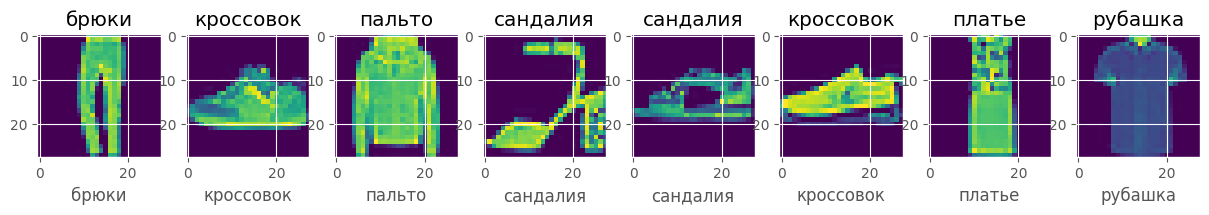

In [6]:
import matplotlib.pyplot as plt
import numpy as np


def plot_data(x: np.array, y: np.array, img_num=8, true_y:np.array=None)->None:
    plt.style.use('ggplot')
    target_dict = {
    0:'футболка',
    1:'брюки',
    2:'свитер',
    3:'платье',
    4:'пальто',
    5:'сандалия',
    6:'рубашка',
    7:'кроссовок',
    8:'сумка',
    9:'сапог',
            }
    inx = np.arange(len(x))
    np.random.shuffle(inx)
    x = x[inx]
    y = y[inx]
    fig, ax = plt.subplots(1, img_num, figsize=(15,8))
    for i in range(img_num):
        img_arr = x[i].reshape(28, 28)
        tgt = y[i].reshape(-1).cpu().item()
        ax[i].imshow(img_arr.cpu())
        ax[i].set_title(f'{target_dict[tgt]}')
        if true_y is not None:
            true_tgt = true_y[inx]
            true_tgt = true_y[i].reshape(-1).cpu().item()
            ax[i].set_xlabel(f'{target_dict[tgt]}')
        

plot_data(train_x_ten, train_y_ten, true_y=train_y_ten)

### <a id=8>Augmentation</a>


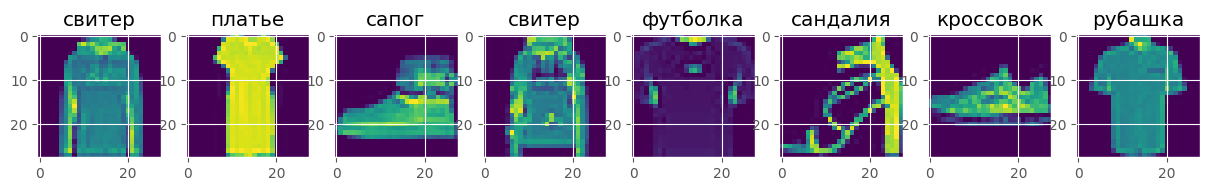

In [11]:
from torchvision import transforms

x_trans = transforms.Compose([
transforms.RandomHorizontalFlip(p=0.5),
transforms.RandomVerticalFlip(p=0.5),
    ])

val_trans = transforms.Compose([
transforms.RandomErasing()
    ])
train_x_aug = x_trans(train_x_ten)
val_x_aug = val_trans(val_x_ten)
plot_data(train_x_aug, train_y_ten)

___
## <center><a id=9 style='color:red'>Модель</a>

### <a id=10> Model architecture</a>


In [12]:
from torch import nn
from torchsummary import summary


class FmnistNN(nn.Module):
    def __init__(self):
        super(FmnistNN, self).__init__()
        
        self.ConvBlock1 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=20, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm2d(num_features=20), 
            torch.nn.MaxPool2d(kernel_size=2, stride=2), 
            torch.nn.Dropout(p=0.6))

        self.ConvBlock2 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=20, out_channels=36, kernel_size=3, padding=0),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm2d(num_features=36))

        self.ConvBlock3 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=36, out_channels=48, kernel_size=3, padding=0),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm2d(num_features=48))

        self.ConvBlock4 = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=48, out_channels=64, kernel_size=3, padding=1),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm2d(num_features=64),
            torch.nn.MaxPool2d(kernel_size=2, stride=2),
            torch.nn.Dropout(p=0.6))

        self.LinearBlock1 = torch.nn.Sequential(
            torch.nn.Linear(5*5*64, 120),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm1d(num_features=120))

        self.LinearBlock2 = torch.nn.Sequential(
            torch.nn.Linear(120, 64),
            torch.nn.LeakyReLU(),
            torch.nn.BatchNorm1d(num_features=64))


        self.LinearBlock3 = torch.nn.Sequential(
            torch.nn.Linear(64, 10),
            torch.nn.Softmax(dim=1))

    def forward(self, x):
        x = self.ConvBlock1(x)
        x = self.ConvBlock2(x)
        x = self.ConvBlock3(x)
        x = self.ConvBlock4(x)
        x = x.view(x.shape[0], x.shape[1] * x.shape[2] * x.shape[3])
        
        x = self.LinearBlock1(x)
        x = self.LinearBlock2(x)
        x = self.LinearBlock3(x)

        return x

model = FmnistNN().to('cuda:0')
summary(model=model, input_size=(1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 20, 28, 28]             200
         LeakyReLU-2           [-1, 20, 28, 28]               0
       BatchNorm2d-3           [-1, 20, 28, 28]              40
         MaxPool2d-4           [-1, 20, 14, 14]               0
           Dropout-5           [-1, 20, 14, 14]               0
            Conv2d-6           [-1, 36, 12, 12]           6,516
         LeakyReLU-7           [-1, 36, 12, 12]               0
       BatchNorm2d-8           [-1, 36, 12, 12]              72
            Conv2d-9           [-1, 48, 10, 10]          15,600
        LeakyReLU-10           [-1, 48, 10, 10]               0
      BatchNorm2d-11           [-1, 48, 10, 10]              96
           Conv2d-12           [-1, 64, 10, 10]          27,712
        LeakyReLU-13           [-1, 64, 10, 10]               0
      BatchNorm2d-14           [-1, 64,

### <a id=11> Training function</a>

In [9]:
from IPython import display
from tqdm import trange
import matplotlib.pyplot as plt
import torch
import numpy as np
from torchvision import transforms


def train_model(model, device, loss, optimizer, scheduler=None, num_epochs=10, batch_size = 20, train_aug=True, val_aug = False):
    train_loss_history, val_loss_history , train_acc_history, val_acc_history = [], [],[], []
    epoch_loss_train, epoch_acc_train, epoch_loss_val, epoch_acc_val = [], [],[], []
    
    VAL_SAMPLES_N = val_x_ten.shape[0]
    TRAIN_SAMPLES_N = train_x_ten.shape[0]

######## Итерации по эпохам ###################################

    for epoch in trange(num_epochs):

        sh_order = np.random.permutation(TRAIN_SAMPLES_N)

######## Итерации по батчам ###################################

        for start_inx in range(0, TRAIN_SAMPLES_N, batch_size):
            batch_inx = sh_order[start_inx:start_inx + batch_size]
            if train_aug == True:
                x_batch = train_x_aug[batch_inx].to(device=device)
            else:
                x_batch = train_x_ten[batch_inx].to(device=device)
            y_batch = train_y_ten[batch_inx].to(device=device)

######## Прямой - Обратный проход #############################

            model.train()
            optimizer.zero_grad()
            preds = model(x_batch)
            loss_value = loss(preds, y_batch)
            preds_class = preds.argmax(dim=1)
            loss_value.backward()
            optimizer.step()
            scheduler.step(loss_value)

######## Метрики качества при обучении ########################

            batch_loss_train = loss(preds, y_batch).data.cpu()
            batch_acc_train = ( preds_class == y_batch).float().mean().data.cpu()
            train_loss_history.append( batch_loss_train )
            train_acc_history.append(batch_acc_train.cpu() )
        epoch_loss_train.append(np.array(train_loss_history).mean())
        epoch_acc_train.append(np.array(train_acc_history).mean())

######## Метрики качества при валидации #######################

        sh_order = np.random.permutation(VAL_SAMPLES_N)
        for start_inx in range(0, VAL_SAMPLES_N, batch_size):
            batch_inx = sh_order[start_inx:start_inx + batch_size]
            if val_aug == True:
                x_batch = val_x_aug[batch_inx].to(device=device)
            else:
                x_batch = val_x_ten[batch_inx].to(device=device)
            y_batch = val_y_ten[batch_inx].to(device=device)

            model.eval()
            val_preds = model.forward(x_batch)
            batch_loss_val = loss(val_preds, y_batch).data.cpu()
            batch_acc_val = (val_preds.argmax(dim=1) == y_batch).float().mean().data.cpu()
            val_loss_history.append( batch_loss_val )
            val_acc_history.append(batch_acc_val.cpu() )
        epoch_loss_val.append(np.array(val_loss_history).mean())
        epoch_acc_val.append(np.array(val_acc_history).mean())

######## Отрисовка средних метрик по эпохам ###################

        plt.style.use('ggplot')
        fig, ax = plt.subplots(1, 2, figsize=(16,7))
        display.clear_output(True)
        plt.figure(figsize=(15,7))
        ax[0].plot(epoch_loss_train, label=f'Train loss: {epoch_loss_train[-1]:.3f}', c='r')
        ax[0].plot(epoch_loss_val, label=f'Val loss: {epoch_loss_val[-1]:.3f}', c='b')
        ax[1].plot(epoch_acc_train, label=f'Train Acc: {epoch_acc_train[-1]:.3f}', c='r')
        ax[1].plot(epoch_acc_val, label=f'Val Acc: {epoch_acc_val[-1]:.3f}', c='b');
        ax[0].legend()
        ax[1].legend();
        ax[0].set_title('Loss')
        ax[1].set_title('Accuracy');
        plt.show();

    return model

### <a id=12>Model training</a>


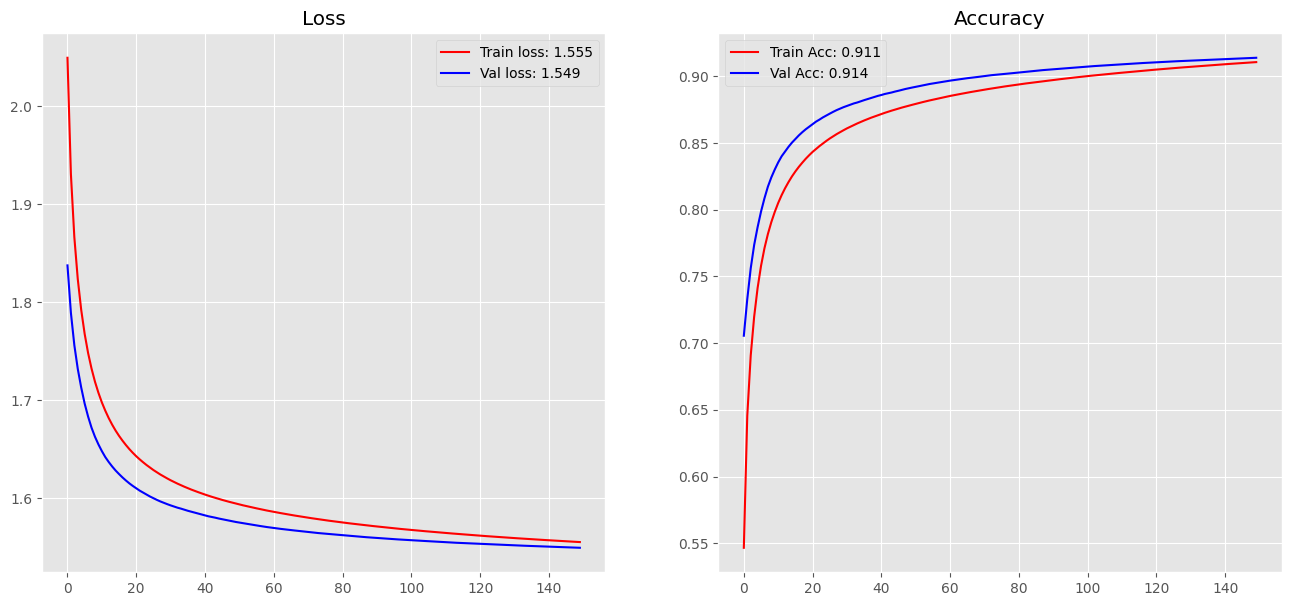

<Figure size 1500x700 with 0 Axes>

100%|██████████| 150/150 [05:34<00:00,  2.23s/it]


In [13]:
from pytorch_lightning import seed_everything
from torch import optim
import torch

seed_everything(seed=42)

device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
model.to(device)

optimizer = optim.Adam( model.parameters(), lr=0.0003)
loss_func = torch.nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode='min', patience=5600, factor=0.9)

trained_model = train_model(model=model,
            device=device,
            loss=loss_func,
            optimizer=optimizer,
            scheduler=scheduler,
            num_epochs=150,
            batch_size=1350,
            train_aug=True);

### <a id=13>Model evaluating</a>


Accuracy score: 0.9292
Classification report:
               precision    recall  f1-score   support

    футболка       0.87      0.91      0.89       622
       брюки       0.99      0.99      0.99       601
      свитер       0.89      0.89      0.89       592
      платье       0.93      0.96      0.94       637
      пальто       0.89      0.88      0.88       596
    сандалия       0.99      0.98      0.98       588
     рубашка       0.83      0.78      0.80       631
   кроссовок       0.96      0.97      0.96       577
       сумка       0.99      0.99      0.99       570
       сапог       0.96      0.97      0.96       586

    accuracy                           0.93      6000
   macro avg       0.93      0.93      0.93      6000
weighted avg       0.93      0.93      0.93      6000



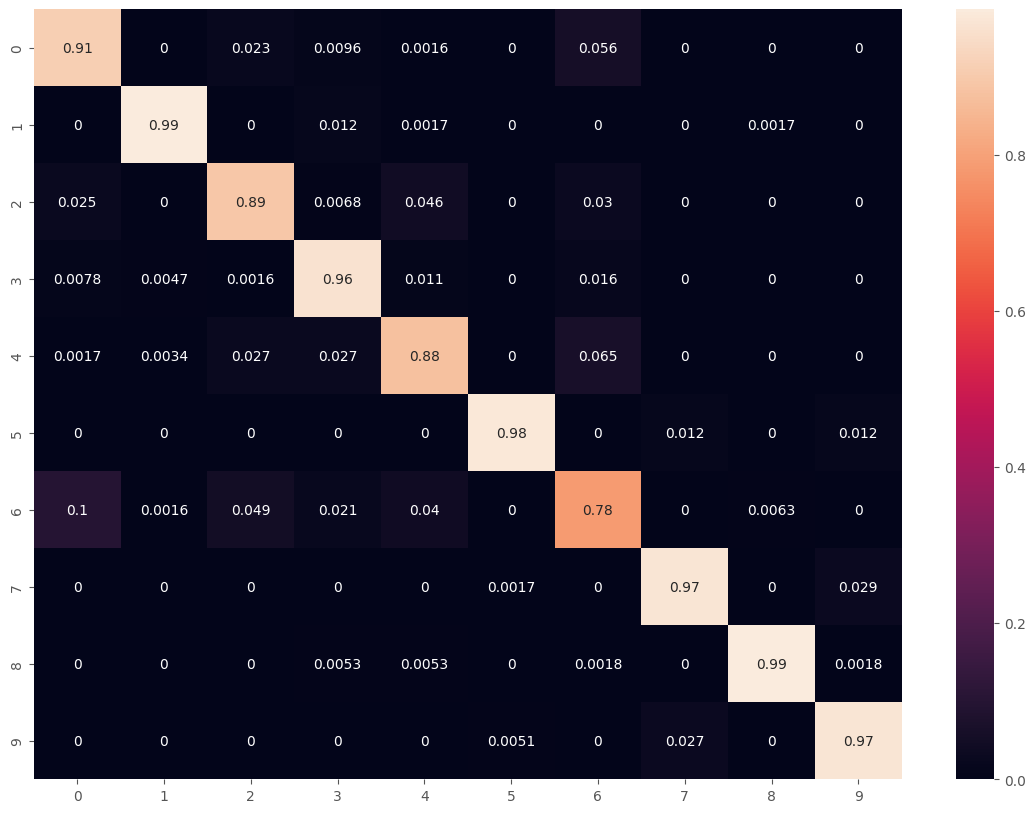

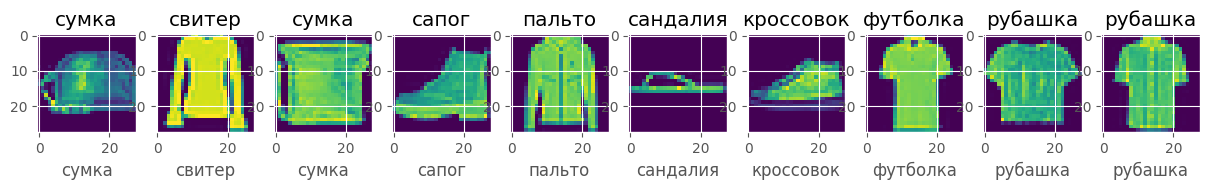

In [14]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

model.eval()

y_pred = model(val_x_ten)
pred_classes = y_pred.argmax(dim=1)

accuracy = ( pred_classes == val_y_ten).float().mean().data.cpu().item()

target_list = ['футболка', 'брюки', 'свитер','платье', 'пальто',
            'сандалия', 'рубашка', 'кроссовок', 'сумка', 'сапог']

matrix = confusion_matrix(val_y_ten.data.cpu(), pred_classes.cpu(), normalize='true')
plt.figure(figsize=(14,10))
sns.heatmap(matrix, annot=True)

report = classification_report(val_y_ten.data.cpu(),  pred_classes.cpu(), target_names=target_list)
print(f'Accuracy score: {accuracy:.4f}')
print("Classification report:\n", report)

plot_data(val_x_ten, pred_classes, img_num=10, true_y=val_y_ten)

### <a id=14>Model saving</a>

In [ ]:
torch.save(model, f'data/models/model_{accuracy:.3f}.pkl')

### <a id=15>Model loading</a>

In [ ]:
model_path = 'data\models\model_0.921.pkl'
model_ld = torch.load(model_path)
model_ld.eval()
prediction = model_ld(val_x_ten)

___
## <center><a id=16 style='color:red'>Запись результатов</a>

In [ ]:
import os
import numpy as np
import time
import pandas as pd

model.eval()
y_pred = model(test_x_ten)
pred_classes = y_pred.argmax(dim=1)

def record_submition(sample_path: str = 'data/sample_submission.csv',
                   submition_path: str='data/submitions',
                   submition_column: str='Category',
                   model_result: torch.Tensor=pred_classes,
                   accuracy_value: int=accuracy) -> None:
    """Запись результата предсказания модели в csv-файл

    Args:
        sample_path (str, optional): Путь к csv-примеру. Defaults to 'data/sample_submission.csv'.
        submition_path (str, optional): Путь к папке с результатами (csv). Defaults to 'data/submitions'.
        submition_column (str, optional): Столбец, в котором находится таргет. Defaults to 'Category'.
        model_result (torch.Tensor, optional): Результат предсказания модели. Defaults to pred_classes.
        accuracy_value (int, optional): Точность предсказания. Defaults to accuracy.
    """
    df_sample = pd.read_csv(sample_path, index_col=False)
    df_result = df_sample.copy()

    df_result[submition_column] = model_result.cpu().data
    date = time.ctime().replace(' ', '_').replace(':', '_')[:-8]

    file_name = f'Fmnist_{date}_{accuracy_value:.3f}.csv'
    result_path = os.path.join(submition_path, file_name)
    df_result.to_csv(result_path, index=False)
    print(f'{file_name} recorded!')


record_submition()

Fmnist_Mon_Apr_29_09_56_0.895.csv recorded!
